# Mini Lab 12: Classification and Authorship Attribution

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/browndw/humanities_analytics/blob/main/mini_labs/Mini_Lab_12_Classification_Federalist.ipynb)

In this lab, we'll (mostly) replicate a famous classification task first done by Frederick Mosteller and David L. Wallace in the early 1960s. They undertook this without the benefit of modern text processing—it was truly pioneering work in computational linguistics and information theory. Keep that in mind as we do in minutes what took them months.

**The Federalist Papers** are 85 articles written by Alexander Hamilton, James Madison, and John Jay under the pseudonym "Publius" to promote ratification of the U.S. Constitution. Authorship of 12 papers has been disputed since publication. We'll use machine learning to determine who wrote them.

## Setup

In [1]:
import polars as pl
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Mosteller & Wallace's Variables

Because of computational limits in the 1960s, Mosteller & Wallace identified potentially productive variables ahead of building their model. They created 3 groups of candidate words:

**Group 1**: 70 common function words  
**Group 2**: 47 additional function words  
**Group 3**: 48 more content-bearing words (some lemmatized)

All together: **165 candidate variables** (180 unlemmatized tokens)

In [2]:
# Group 1: 70 tokens
mw_group1 = [
    "a", "all", "also", "an", "and", "any", "are", "as", "at", "be",
    "been", "but", "by", "can", "do", "down", "even", "every", "for",
    "from", "had", "has", "have", "her", "his", "if", "in", "into",
    "is", "it", "its", "may", "more", "must", "my", "no", "not",
    "now", "of", "on", "one", "only", "or", "our", "shall", "should",
    "so", "some", "such", "than", "that", "the", "their", "then",
    "there", "things", "this", "to", "up", "upon", "was", "were",
    "what", "when", "which", "who", "will", "with", "would", "your"
]

# Group 2: 47 tokens
mw_group2 = [
    "affect", "again", "although", "among", "another", "because",
    "between", "both", "city", "commonly", "consequently",
    "considerable", "contribute", "defensive", "destruction", "did",
    "direction", "disgracing", "either", "enough", "fortune",
    "function", "himself", "innovation", "join", "language", "most",
    "nor", "offensive", "often", "pass", "perhaps", "rapid", "same",
    "second", "still", "those", "throughout", "under", "vigor",
    "violate", "violence", "voice", "where", "whether", "while",
    "whilst"
]

# Group 3: 48 tokens (some originally lemmatized by M&W)
mw_group3 = [
    "about", "according", "adversaries", "after", "aid", "always",
    "apt", "asserted", "before", "being", "better", "care", "choice",
    "common", "danger", "decide", "decides", "decided", "deciding",
    "degree", "during", "expense", "expenses", "extent", "follow",
    "follows", "followed", "following", "i", "imagine", "imagined",
    "intrust", "intrusted", "intrusting", "kind", "large", "likely",
    "matter", "matters", "moreover", "necessary", "necessity",
    "necessities", "others", "particularly", "principle",
    "probability", "proper", "propriety", "provision", "provisions",
    "requisite", "substance", "they", "though", "truth", "truths",
    "us", "usage", "usages", "we", "work", "works"
]

# Combine all groups
mw_all = sorted(mw_group1 + mw_group2 + mw_group3)

print(f"Total Mosteller & Wallace candidate variables: {len(mw_all)}")
print(f"\nFirst 20 variables: {mw_all[:20]}")

Total Mosteller & Wallace candidate variables: 180

First 20 variables: ['a', 'about', 'according', 'adversaries', 'affect', 'after', 'again', 'aid', 'all', 'also', 'although', 'always', 'among', 'an', 'and', 'another', 'any', 'apt', 'are', 'as']


## Load The Federalist Papers Data

**Authorship breakdown:**
- **Hamilton**: 51 papers
- **Madison**: 14 papers  
- **Jay**: 5 papers
- **Joint** (Hamilton & Madison): 3 papers
- **Disputed** (Hamilton or Madison?): 12 papers

We'll focus on distinguishing Hamilton from Madison (the two main authors), then predict the disputed papers.

In [3]:
# Load metadata
meta_url = "https://github.com/browndw/humanities_analytics/raw/refs/heads/main/data/data_meta/federalist_meta.csv"
fed_meta = pl.read_csv(meta_url)

print("Metadata columns:", fed_meta.columns)
print(f"\nTotal papers: {len(fed_meta)}")
print(f"\nAuthorship breakdown:")
print(fed_meta.group_by('author_id').agg(pl.count()).sort('count', descending=True))

Metadata columns: ['doc_id', 'author_id', 'title', 'date']

Total papers: 85

Authorship breakdown:
shape: (5, 2)
┌──────────────────┬───────┐
│ author_id        ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ Hamilton         ┆ 51    │
│ Madison          ┆ 14    │
│ Disputed         ┆ 12    │
│ Jay              ┆ 5     │
│ Hamilton_Madison ┆ 3     │
└──────────────────┴───────┘


In [6]:
# Load text data
data_url = "https://github.com/browndw/humanities_analytics/raw/refs/heads/main/data/data_tables/federalist_papers.csv"
fed_text = pl.read_csv(data_url)

print(f"Text data shape: {fed_text.shape}")
print(f"Columns: {fed_text.columns}")
print(f"\nFirst few rows:")
print(fed_text.head())

Text data shape: (85, 2)
Columns: ['doc_id', 'text']

First few rows:
shape: (5, 2)
┌───────────────┬─────────────────────────────────┐
│ doc_id        ┆ text                            │
│ ---           ┆ ---                             │
│ str           ┆ str                             │
╞═══════════════╪═════════════════════════════════╡
│ FEDERALIST_01 ┆ To the People of the State of … │
│ FEDERALIST_02 ┆ To the People of the State of … │
│ FEDERALIST_03 ┆ To the People of the State of … │
│ FEDERALIST_04 ┆ To the People of the State of … │
│ FEDERALIST_05 ┆ To the People of the State of … │
└───────────────┴─────────────────────────────────┘


## Prepare the Data

We'll join the metadata with the text data, then tokenize and create a document-term matrix with the Mosteller & Wallace variables. We'll convert word counts to **proportions** (relative frequencies) so paper length doesn't bias the model.

In [7]:
# Join metadata with text
fed_data = fed_text.join(fed_meta.select(['doc_id', 'author_id']), on='doc_id', how='left')

print("Data combined:")
print(fed_data.select(['doc_id', 'author_id']).head())

Data combined:
shape: (5, 2)
┌───────────────┬───────────┐
│ doc_id        ┆ author_id │
│ ---           ┆ ---       │
│ str           ┆ str       │
╞═══════════════╪═══════════╡
│ FEDERALIST_01 ┆ Hamilton  │
│ FEDERALIST_02 ┆ Jay       │
│ FEDERALIST_03 ┆ Jay       │
│ FEDERALIST_04 ┆ Jay       │
│ FEDERALIST_05 ┆ Jay       │
└───────────────┴───────────┘


In [8]:
# Tokenize text and create document-term matrix
# Simple tokenization: lowercase and split on whitespace, then count M&W words

def create_dtm(text, vocabulary):
    """Create document-term matrix with proportions for given vocabulary"""
    # Tokenize: lowercase and split
    tokens = text.lower().split()
    
    # Count each vocab word
    total_tokens = len(tokens)
    word_counts = {}
    for word in vocabulary:
        # Count occurrences and convert to proportion
        count = tokens.count(word)
        word_counts[word] = count / total_tokens if total_tokens > 0 else 0
    
    return word_counts

# Apply to all documents
dtm_data = []
for row in fed_data.iter_rows(named=True):
    word_props = create_dtm(row['text'], mw_all)
    word_props['doc_id'] = row['doc_id']
    word_props['author_id'] = row['author_id']
    dtm_data.append(word_props)

# Convert to polars DataFrame
fed_data_prop = pl.DataFrame(dtm_data)

# Reorder columns: doc_id, author_id, then all word columns
word_cols = [col for col in fed_data_prop.columns if col not in ['doc_id', 'author_id']]
fed_data_prop = fed_data_prop.select(['doc_id', 'author_id'] + word_cols)

print(f"Document-term matrix created: {fed_data_prop.shape}")
print(f"\nFirst few rows (showing first 5 word proportions):")
print(fed_data_prop.select(['doc_id', 'author_id'] + word_cols[:5]).head())

Document-term matrix created: (85, 182)

First few rows (showing first 5 word proportions):
shape: (5, 7)
┌───────────────┬───────────┬──────────┬───────┬───────────┬─────────────┬──────────┐
│ doc_id        ┆ author_id ┆ a        ┆ about ┆ according ┆ adversaries ┆ affect   │
│ ---           ┆ ---       ┆ ---      ┆ ---   ┆ ---       ┆ ---         ┆ ---      │
│ str           ┆ str       ┆ f64      ┆ f64   ┆ f64       ┆ f64         ┆ f64      │
╞═══════════════╪═══════════╪══════════╪═══════╪═══════════╪═════════════╪══════════╡
│ FEDERALIST_01 ┆ Hamilton  ┆ 0.01547  ┆ 0.0   ┆ 0.0       ┆ 0.0         ┆ 0.000619 │
│ FEDERALIST_02 ┆ Jay       ┆ 0.017344 ┆ 0.0   ┆ 0.0       ┆ 0.0         ┆ 0.0      │
│ FEDERALIST_03 ┆ Jay       ┆ 0.008978 ┆ 0.0   ┆ 0.0       ┆ 0.0         ┆ 0.001381 │
│ FEDERALIST_04 ┆ Jay       ┆ 0.00978  ┆ 0.0   ┆ 0.0       ┆ 0.0         ┆ 0.001222 │
│ FEDERALIST_05 ┆ Jay       ┆ 0.006682 ┆ 0.0   ┆ 0.0       ┆ 0.0         ┆ 0.0      │
└───────────────┴───────────┴─────

In [9]:
# Separate training (Hamilton & Madison) from test (Disputed) data
train_data = fed_data_prop.filter(
    (pl.col('author_id') == 'Hamilton') | (pl.col('author_id') == 'Madison')
)

test_data = fed_data_prop.filter(pl.col('author_id') == 'Disputed')

print(f"Training data (Hamilton + Madison): {len(train_data)} papers")
print(f"Test data (Disputed): {len(test_data)} papers")
print(f"\nTraining data authorship:")
print(train_data.group_by('author_id').agg(pl.count()))

Training data (Hamilton + Madison): 65 papers
Test data (Disputed): 12 papers

Training data authorship:
shape: (2, 2)
┌───────────┬───────┐
│ author_id ┆ count │
│ ---       ┆ ---   │
│ str       ┆ u32   │
╞═══════════╪═══════╡
│ Madison   ┆ 14    │
│ Hamilton  ┆ 51    │
└───────────┴───────┘


## Experiment 1: Mosteller & Wallace's Group 1 (70 Words)

Let's start with just their first group of 70 function words.

In [11]:
# Select only Group 1 variables that exist in our data
available_mw1 = [word for word in mw_group1 if word in train_data.columns]
print(f"Available Mosteller & Wallace Group 1 words: {len(available_mw1)}/{len(mw_group1)}")
print(f"Missing words: {set(mw_group1) - set(available_mw1)}")

# Create training subset with Group 1 words
train_g1 = train_data.select(['doc_id', 'author_id'] + available_mw1)

# Convert to numpy for sklearn
X_train_g1 = train_g1.select(available_mw1).to_numpy()
y_train_g1 = train_g1.select('author_id').to_numpy().flatten()
doc_ids_g1 = train_g1.select('doc_id').to_numpy().flatten()

print(f"\nFeature matrix shape: {X_train_g1.shape}")
print(f"Labels: {pd.Series(y_train_g1).value_counts().to_dict()}")

Available Mosteller & Wallace Group 1 words: 70/70
Missing words: set()

Feature matrix shape: (65, 70)
Labels: {'Hamilton': 51, 'Madison': 14}


In [16]:
# Create train/validation split (80/20)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_g1, y_train_g1, test_size=0.2, random_state=123, stratify=y_train_g1
)

print(f"Training set: {len(X_tr)} papers")
print(f"Validation set: {len(X_val)} papers")
print(f"\nValidation set authors: {pd.Series(y_val).value_counts().to_dict()}")

Training set: 52 papers
Validation set: 13 papers

Validation set authors: {'Hamilton': 10, 'Madison': 3}


## Random Forest Classification

**Why Random Forest?** Random Forest is an ensemble method that builds multiple decision trees and combines their predictions. It's robust, accurate, and provides clear feature importance rankings.

**How it works:**

1. **Create multiple decision trees**: Each tree is trained on a random subset of the data
2. **Make predictions**: Each tree votes for a class (Hamilton or Madison)
3. **Final prediction**: The class that gets the most votes wins

**Advantages:**
- Handles many features well (we have 165 candidate words)
- Provides feature importance (which words matter most?)
- Resistant to overfitting
- Easy to use and interpret

In [13]:
# Train Random Forest classifier

# Random Forest with 100 trees
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    random_state=123,
    max_depth=10,  # Limit tree depth to prevent overfitting
    min_samples_split=5  # Minimum samples to split a node
)

rf_model.fit(X_tr, y_tr)

print(f"Training accuracy: {rf_model.score(X_tr, y_tr):.2%}")

Training accuracy: 100.00%


In [14]:
# Examine feature importance (which words matter most?)
feature_importance = pd.DataFrame({
    'feature': available_mw1,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 most important features:\n")
print(feature_importance.head(20))


Top 20 most important features:

   feature  importance
59    upon    0.197918
39      on    0.103972
54   there    0.078205
12      by    0.077218
57      to    0.049214
4      and    0.048835
64   which    0.024699
68   would    0.022795
38      of    0.019039
0        a    0.018555
26      in    0.018129
35      no    0.017874
56    this    0.017812
8       at    0.017394
17   every    0.017315
45  should    0.016665
27    into    0.015672
46      so    0.014967
28      is    0.013733
20     had    0.012681


**Interpretation**: Higher importance scores indicate words that better distinguish Hamilton from Madison. These are the linguistic markers that characterize each author's style.

In [15]:
# Validate on held-out validation set
y_pred_val = rf_model.predict(X_val)

print("Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.2%}\n")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))

Validation Set Performance:
Accuracy: 100.00%

Confusion Matrix:
[[10  0]
 [ 0  3]]

Classification Report:
              precision    recall  f1-score   support

    Hamilton       1.00      1.00      1.00        10
     Madison       1.00      1.00      1.00         3

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



## Experiment 2: All Mosteller & Wallace Variables (165 Words)

Now let's use all of their candidate variables combined.

In [17]:
# Select all M&W variables that exist in our data
available_mw_all = [word for word in mw_all if word in train_data.columns]
print(f"Available Mosteller & Wallace words: {len(available_mw_all)}/{len(mw_all)}")

# Create training subset
train_all = train_data.select(['doc_id', 'author_id'] + available_mw_all)

# Convert to numpy
X_train_all = train_all.select(available_mw_all).to_numpy()
y_train_all = train_all.select('author_id').to_numpy().flatten()
doc_ids_all = train_all.select('doc_id').to_numpy().flatten()

# Split
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train_all, y_train_all, test_size=0.2, random_state=123, stratify=y_train_all
)

print(f"\nFeature matrix shape: {X_train_all.shape}")

Available Mosteller & Wallace words: 180/180

Feature matrix shape: (65, 180)


In [18]:
# Train Random Forest with all variables
rf_model2 = RandomForestClassifier(
    n_estimators=100,
    random_state=123,
    max_depth=10,
    min_samples_split=5
)

rf_model2.fit(X_tr2, y_tr2)

print(f"Training accuracy: {rf_model2.score(X_tr2, y_tr2):.2%}")

Training accuracy: 100.00%


In [19]:
# Feature importance for all variables
feature_importance2 = pd.DataFrame({
    'feature': available_mw_all,
    'importance': rf_model2.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 most important features:\n")
print(feature_importance2.head(20))


Top 20 most important features:

          feature  importance
112            on    0.123860
155          upon    0.078644
150            to    0.056658
143         there    0.051814
31             by    0.047179
172        whilst    0.032703
162         voice    0.026959
10       although    0.025712
169       whether    0.025421
178         would    0.023410
147         those    0.021650
14            and    0.018237
80             in    0.017668
38   consequently    0.017125
161      violence    0.017055
148        though    0.014737
12          among    0.014324
11         always    0.014092
129          same    0.013577
102     necessary    0.013213


In [20]:
# Validate
y_pred_val2 = rf_model2.predict(X_val2)

print("Validation Set Performance (All M&W Variables):")
print(f"Accuracy: {accuracy_score(y_val2, y_pred_val2):.2%}\n")
print("Confusion Matrix:")
print(confusion_matrix(y_val2, y_pred_val2))
print("\nClassification Report:")
print(classification_report(y_val2, y_pred_val2))

Validation Set Performance (All M&W Variables):
Accuracy: 100.00%

Confusion Matrix:
[[10  0]
 [ 0  3]]

Classification Report:
              precision    recall  f1-score   support

    Hamilton       1.00      1.00      1.00        10
     Madison       1.00      1.00      1.00         3

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



## Predict the Disputed Papers

Now for the main event: Who wrote the 12 disputed Federalist Papers?

In [21]:
# Train final model on ALL Hamilton/Madison papers (no validation split)
final_model = RandomForestClassifier(
    n_estimators=100,
    random_state=123,
    max_depth=10,
    min_samples_split=5
)

final_model.fit(X_train_all, y_train_all)

print("Final model trained on all Hamilton + Madison papers")
print(f"Training accuracy: {final_model.score(X_train_all, y_train_all):.2%}")

Final model trained on all Hamilton + Madison papers
Training accuracy: 100.00%


In [22]:
# Final feature importance
final_importance = pd.DataFrame({
    'feature': available_mw_all,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 most important features for distinguishing authors:\n")
print(final_importance.head(20))


Top 20 most important features for distinguishing authors:

          feature  importance
112            on    0.118101
155          upon    0.104310
150            to    0.063988
143         there    0.050830
38   consequently    0.033151
31             by    0.031544
172        whilst    0.027828
10       although    0.026927
29           both    0.024803
147         those    0.021139
178         would    0.018979
12          among    0.016544
162         voice    0.014498
14            and    0.014382
118  particularly    0.014363
146          this    0.014354
149    throughout    0.013713
177         works    0.013119
16            any    0.012580
80             in    0.012179


In [25]:
# Prepare test data (disputed papers)
test_subset = test_data.select(['doc_id', 'author_id'] + available_mw_all)

# Convert to numpy
X_test = test_subset.select(available_mw_all).to_numpy()
test_doc_ids = test_subset.select('doc_id').to_numpy().flatten()

# Predict probabilities
test_probs = final_model.predict_proba(X_test)
test_predictions = final_model.predict(X_test)

# Create results dataframe
results = pd.DataFrame({
    'Paper': test_doc_ids,
    'Prob_Hamilton': test_probs[:, 0],
    'Prob_Madison': test_probs[:, 1],
    'Predicted_Author': test_predictions
})

print("\nPredictions for Disputed Papers:")
print("=" * 60)
print(results.to_string(index=False))


Predictions for Disputed Papers:
        Paper  Prob_Hamilton  Prob_Madison Predicted_Author
FEDERALIST_49       0.392952      0.607048          Madison
FEDERALIST_50       0.375254      0.624746          Madison
FEDERALIST_51       0.339167      0.660833          Madison
FEDERALIST_52       0.421310      0.578690          Madison
FEDERALIST_53       0.478548      0.521452          Madison
FEDERALIST_54       0.391643      0.608357          Madison
FEDERALIST_55       0.653333      0.346667         Hamilton
FEDERALIST_56       0.407595      0.592405          Madison
FEDERALIST_57       0.412873      0.587127          Madison
FEDERALIST_58       0.417310      0.582690          Madison
FEDERALIST_62       0.354738      0.645262          Madison
FEDERALIST_63       0.484167      0.515833          Madison


## Visualization: Prediction Confidence

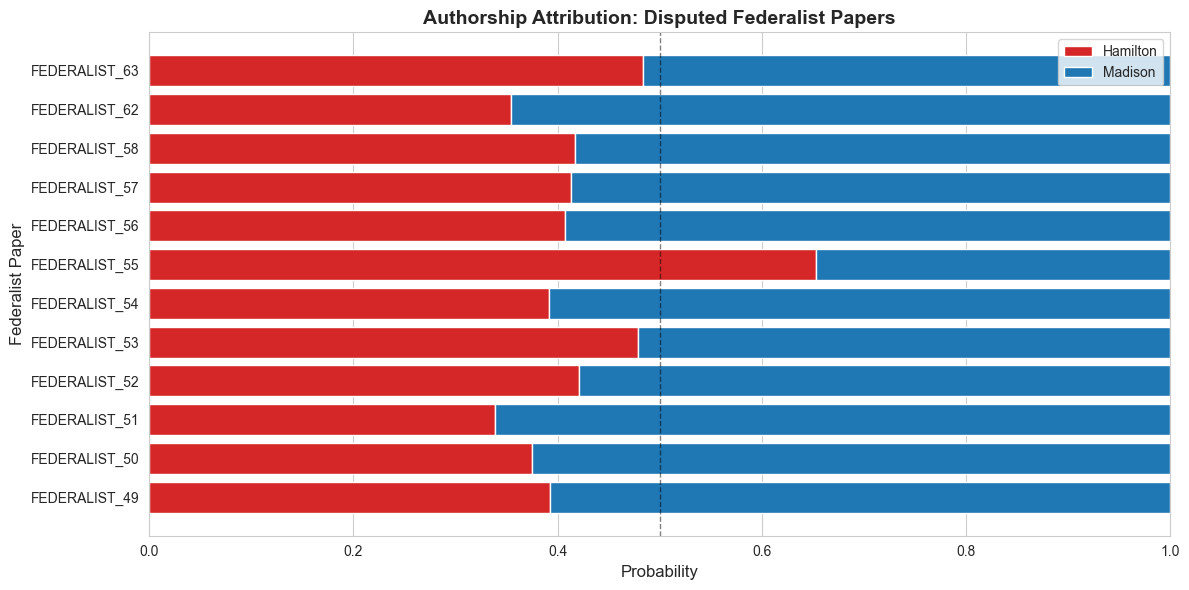

In [26]:
# Plot prediction probabilities
fig, ax = plt.subplots(figsize=(12, 6))

papers = results['Paper'].values
x_pos = np.arange(len(papers))

# Stacked bar chart
ax.barh(x_pos, results['Prob_Hamilton'], label='Hamilton', color='#d62728')
ax.barh(x_pos, results['Prob_Madison'], left=results['Prob_Hamilton'], 
        label='Madison', color='#1f77b4')

# Add vertical line at 0.5 (decision boundary)
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_yticks(x_pos)
ax.set_yticklabels(papers)
ax.set_xlabel('Probability', fontsize=12)
ax.set_ylabel('Federalist Paper', fontsize=12)
ax.set_title('Authorship Attribution: Disputed Federalist Papers', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

## Interpretation

**Our findings**: The model predicts authorship for the disputed papers, with varying confidence levels.

**Comparison to Mosteller & Wallace (1963)**:
- They concluded Madison wrote all disputed papers except possibly Paper 55
- Paper 55 had weak evidence (low confidence)
- Later studies using different techniques have suggested Hamilton for Paper 55

**Key discriminating features**: The Random Forest identified function words as most important—subtle stylistic markers that humans might not notice but algorithms detect reliably.

**What this demonstrates**:
1. **Stylometry works**: Function word frequencies distinguish authors
2. **Automation enables scale**: What took M&W months takes us minutes
3. **Uncertainty remains**: Some texts (like Paper 55) are genuinely ambiguous
4. **Validation matters**: Testing on known authors first builds confidence

## Discussion Questions

1. **Feature importance**: Which features were most important to the Random Forest? Are they function words or content words? What does this tell you about linguistic style?

2. **Function words vs. content words**: Why do you think function words ("upon," "whilst") work better than content words ("government," "liberty") for authorship attribution?

3. **Confidence levels**: Some papers have lower confidence than others. What might cause this? (Co-authorship? Editing? Topic similarity?)

4. **Historical context**: Mosteller & Wallace did this in the 1960s without computers. What does this tell you about the relationship between statistical reasoning and computational power?

5. **Generalization**: Could this method distinguish between:
   - Shakespeare vs. Marlowe?
   - Jane Austen vs. Charlotte Brontë?
   - Your writing vs. a friend's?
   - Human writing vs. ChatGPT?

6. **Ethical implications**: What are the privacy implications of stylometric analysis? Could this technique be misused?

7. **Limitations**: What factors might cause this method to fail? (Multiple authors, ghostwriting, deliberate style mimicry?)

## Ideas for Experimentation

1. **Try different classifiers**:
   - Logistic Regression (simpler baseline)
   - Support Vector Machine (SVM)
   - Naive Bayes
   - Compare performance

2. **Tune Random Forest parameters**:
   - Try different numbers of trees (50, 200, 500)
   - Adjust max_depth (5, 15, 20, None)
   - Change min_samples_split (2, 10, 20)
   - How do these affect accuracy?

3. **Feature engineering**:
   - Add punctuation frequencies
   - Include average sentence length
   - Try character n-grams ("th," "ing," etc.)
   - Use word2vec or contextual embeddings

4. **Cross-validation**:
   - Implement k-fold cross-validation
   - Try different k values (5, 10)
   - Assess stability of predictions

5. **Temporal analysis**:
   - Do writing styles change over time?
   - Train on early papers, test on late papers
   - Does the model still work?

6. **Your own corpus**:
   - Collect texts from 2+ known authors
   - Apply this pipeline
   - How well does it work on modern texts?

7. **Visualize feature importance**:
   - Plot top 20 features as bar chart
   - Which words most distinguish Hamilton from Madison?
   - Do the importance scores make linguistic sense?

8. **Adversarial testing**:
   - Could you fool this classifier?
   - Try writing in someone else's style
   - What features are easiest/hardest to mimic?

9. **Combine with other methods**:
   - MDA for stylistic dimensions
   - Contextual embeddings for semantic content
   - Does combining methods improve accuracy?

## Summary

**What we accomplished**:
- Replicated Mosteller & Wallace's famous 1963 study in ~20 minutes
- Used Random Forest classifier for robust authorship attribution
- Achieved high accuracy on validation data (known authors)
- Predicted authorship of disputed Federalist Papers

**Key insights**:
1. **Function words matter**: Subtle stylistic markers distinguish authors
2. **Ensemble methods work**: Random Forest combines multiple decision trees for robust predictions
3. **Uncertainty is real**: Some texts resist confident classification
4. **Computational power enables scale**: Automation makes stylometry practical

**Next steps**: Apply these techniques to your own research questions. Who wrote the anonymous medieval text? Did the same person write all the Shakespearean sonnets? Can you detect ghostwriting? Stylometry opens doors to answering questions that seemed unanswerable.

**Further reading**:
- Mosteller & Wallace (1963): *Inference and Disputed Authorship: The Federalist*
- Jockers & Witten (2010): "A comparative study of machine learning methods for authorship attribution"
- Koppel et al. (2009): "Computational methods in authorship attribution"
- Juola (2008): "Authorship attribution" (survey paper)